<a href="https://colab.research.google.com/github/hvkchaitanya7/grp3capstoneprj/blob/main/ImageCaptionGroup3_WIP_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Reference (GitHub):- https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb

In [ ]:
!rm -rf Flickr8k_Dataset.zip
!rm -rf Flickr8k_text.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

In [135]:

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import optimizers
from keras import Input, layers
from keras.applications.inception_v3 import preprocess_input
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf

In [104]:
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop

In [6]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [7]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping


In [8]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
descriptions

In [10]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [11]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [13]:
c_descriptions  = clean_descriptions(descriptions)
c_descriptions

In [14]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [15]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')


In [16]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
train

In [18]:
# Below path contains all the images
images = '/content/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [19]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [20]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [21]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [105]:
def preprocess(image_path):
    # Convert all the images to size 224X224 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(224, 224,3))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    #print(x.shape())
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    #x = preprocess_input(x)
    return x

In [106]:
# Load the inception v3 model
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224, 224,3),pooling="avg")

94781440/94765736 [==============================] - 1s 0us/step


In [107]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [25]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
model_new.summary()

In [108]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [109]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 353.74393916130066


In [110]:
pkl_train_file="/content/Pickle_ResNet/encoded_train_images.pkl"

In [111]:
# Save the bottleneck train features to disk
with open(pkl_train_file, "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

    # /content/sample_data/Pickle/encoded_train_images.pkl

In [112]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 56.986233711242676


In [113]:
pkl_test_file = "/content/Pickle_ResNet/encoded_test_images.pkl"

In [114]:

# Save the bottleneck test features to disk
with open(pkl_test_file, "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [115]:
train_features = load(open(pkl_train_file, "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [116]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [117]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [118]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [119]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [120]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [121]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [122]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-07-09 09:28:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-09 09:28:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-09 09:28:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [42]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [43]:
!wget http://nlp.stanford.edu/data/glove.6B.200d.zip

--2022-07-09 07:02:17--  http://nlp.stanford.edu/data/glove.6B.200d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.200d.zip [following]
--2022-07-09 07:02:17--  https://nlp.stanford.edu/data/glove.6B.200d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.200d.zip [following]
--2022-07-09 07:02:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.200d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-09 07:02:17 ERROR 404: Not Found.


In [123]:

# Load Glove vectors
glove_dir = '/content/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [124]:
vocab_size

1652

In [125]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [126]:
embedding_matrix.shape

(1652, 200)

In [ ]:
embedding_matrix[1650,0:50]

In [128]:
max_length

34

In [130]:
img_model = Sequential()
img_model.add(Dense(128,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(max_length))

In [131]:
lang_model = Sequential()
lang_model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
lang_model.add(LSTM(256,return_sequences =True))
lang_model.add(TimeDistributed(Dense(128)))

In [142]:
concat = tf.keras.layers.Concatenate()([img_model.output,lang_model.output])
x = LSTM(128,return_sequences =True)(concat)
x = LSTM(512,return_sequences =False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[img_model.input, lang_model.input], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='RMSProp',metrics=["accuracy"])

In [143]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_1_input (InputLayer)  [(None, 34)]        0           []                               
                                                                                                  
 dense_4_input (InputLayer)     [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 200)      330400      ['embedding_1_input[0][0]']      
                                                                                                  
 dense_4 (Dense)                (None, 128)          262272      ['dense_4_input[0][0]']          
                                                                                            

In [85]:
#model.layers[2].set_weights([embedding_matrix])
#model.layers[2].trainable = False

In [53]:
#model.compile(loss='categorical_crossentropy', optimizer='adam')

In [87]:
#model.compile(loss='categorical_crossentropy', optimizer='RMSProp')

In [144]:
epochs = 15
number_pics_per_bath = 20
steps = len(train_descriptions)//number_pics_per_bath

In [145]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


300/300 [==============================] - 29s 97ms/step - loss: 2.7886 - accuracy: 0.3649


In [146]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

  1/300 [..............................] - ETA: 35s - loss: 2.5754 - accuracy: 0.3990

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


300/300 [==============================] - 29s 98ms/step - loss: 1.9825 - accuracy: 0.5042


In [147]:
model.optimizer.lr = 0.0001
epochs = 15
number_pics_per_bath = 20
steps = len(train_descriptions)//number_pics_per_bath

In [148]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

  1/300 [..............................] - ETA: 35s - loss: 1.8748 - accuracy: 0.5038

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


300/300 [==============================] - 29s 98ms/step - loss: 1.7222 - accuracy: 0.5703


In [149]:
model.save_weights('./model_weights/model_45_resnet_new.h5')

In [150]:
model.load_weights('./model_weights/model_45_resnet_new.h5')

In [151]:
images = '/content/Flicker8k_Dataset/'

In [152]:
with open(pkl_test_file, "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [153]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        #print("yhat from model", yhat )
        yhat = np.argmax(yhat)
        #print(" yhat from argmax",yhat)
        word = ixtoword[yhat]
        #print("word from yhat", word)
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [154]:
def get_bleuscore(pred_desc, image_name):
    cand_desc = pred_desc.split()
    #print("blue score desc", cand_desc)
    img_name = image_name.split(".jpg")[0]
    refer_desc = descriptions[img_name]
    refer_list = []
    for s in refer_desc:
         s = s.split()
         refer_list.append(s)
    #print(s)
    print("Expert Caption:",refer_desc)
    #print (refer_list)
    score = sentence_bleu(refer_list,cand_desc,weights=(0, 1, 0))
    #print(score)
    return(score)

In [65]:
t = "1679617928_a73c1769be.jpg"
t = t.split(".jpg")[0]
t_can = "basset hound is leashed to the rearview mirror of udpated to validate".split()
print(t_can)
refer = descriptions[t]
refer_list = []
for s in refer:
    s = s.split()
    refer_list.append(s)
    #print(s)
#print(refer)
#print (refer_list)
score = sentence_bleu(refer_list,t_can,weights=(0, 1, 0))
#print(score)

['basset', 'hound', 'is', 'leashed', 'to', 'the', 'rearview', 'mirror', 'of', 'udpated', 'to', 'validate']


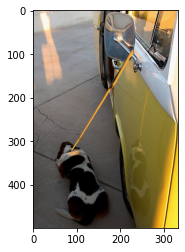

Expert Caption: ['basset hound is leashed to the rearview mirror of yellow and white vehicle', 'black and white dog tied to yellow and white van', 'dog lying down tethered to the side mirror of yellow vw bus', 'dog with black white and brown coloring is leashed up to mirror', 'the black and white dog is tethered next to yellow car']
Blue score 8.18558927632837e-309
caption: child sliding down yellow slide


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


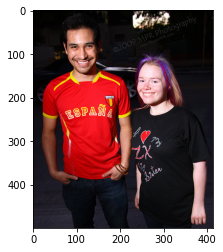

Expert Caption: ['man in red shirt standing next to woman in black shirt with car in the background', 'man in red shirt that says espana and girl with purple streaks in her hair are smiling', 'man with red spain shirt and woman with purple streaks in her hair', 'the man and lady pose for picture', 'the man is wearing red shirt while the woman standing with him has purple streaks in her hair']
Blue score 0.07692307692307693
caption: man with black hair and black outfit stands in front of an empty street


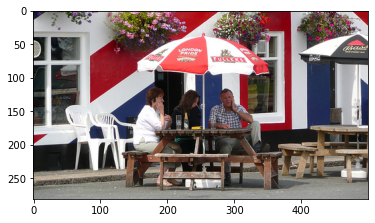

Expert Caption: ['couple of people sit outdoors at table with an umbrella and talk', 'three people are sitting at an outside picnic bench with an umbrella', 'three people sit at an outdoor cafe', 'three people sit at an outdoor table in front of building painted like the union jack', 'three people sit at picnic table outside of building painted like union jack']
Blue score 0.2857142857142857
caption: man is sitting on bench outside of building


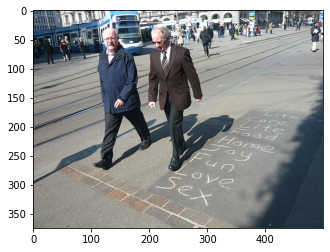

Expert Caption: ['two elderly people walk down city sidewalk by words written in chalk', 'two men walk along busy city street with words printed on the sidewalk', 'two men walk through city with words on the street', 'two older men in business attire are walking in city text graffiti is visible on the sidewalk', 'two people walk down city street that has writing on it']
Blue score 2.2250738585072626e-308
caption: man in black shirt and black shorts is skating in the snow


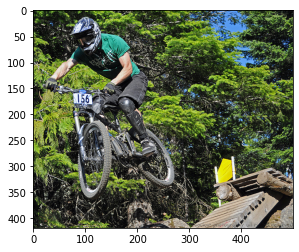

Expert Caption: ['bicyclist wearing helment riding down steep ramp', 'bike rider catches air near ramp', 'bmx rider in midair', 'man wearing green shirt is jumping his bicycle off ramp', 'cyclist in green shirt doing trick on wooden ramp']
Blue score 2.2250738585072626e-308
caption: man in yellow jacket does tricks on dirt bike


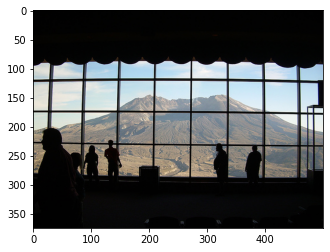

Expert Caption: ['group of people inside building that overlooks large mountain', 'large window with mountain range while onlookers stand in front', 'people look out the window at mountains', 'people stand and look out the window to view the mountain', 'sillhouttes of people in front of mountain and in front of window']
Blue score 2.2250738585072626e-308
caption: two people are sitting on railing near stone


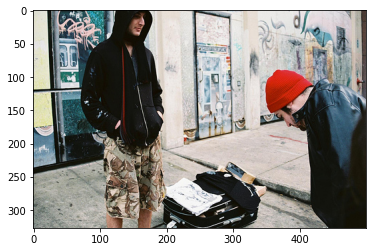

Expert Caption: ['man in black hoodie watching man in red cap', 'man standing on street with suitcase in front of him while another man bends down to look at what is displayed on top of it', 'man wearing red hat looks down as another man watches', 'two men are standing on the street covered in graffiti', 'two people on street one person looking down']
Blue score 0.16666666666666669
caption: man in black shirt is standing by the window of an old man


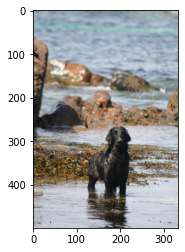

Expert Caption: ['black dog in water', 'black dog standing in shallow area of water on rocky beach', 'dog stands in tide pool', 'small black dog in the ocean with some rocks in the background', 'small black dog plays in the water']
Blue score 2.2250738585072626e-308
caption: dog is running through water


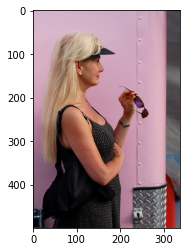

Expert Caption: ['large woman puts her sunglasses on', 'woman in black dress holding sunglasses', 'woman wearing black and white outfit while holding her sunglasses', 'the lady is holding her glasses', 'the woman with blond hair holds her sunglasses']
Blue score 2.2250738585072626e-308
caption: boy in blue shirt looking at camera


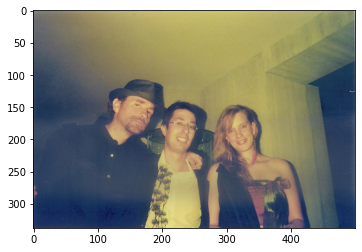

Expert Caption: ['three people stand by doorway posing for photograph', 'two men and woman pose for picture', 'two men and woman smile at the camera', 'two men and woman standing near doorway', 'two men and woman with their arms around each other']
Blue score 1.491511611267286e-308
caption: two girls in front of


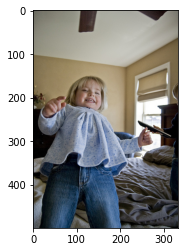

Expert Caption: ['little girl is falling backwards onto bed', 'young girl jumps on bed', 'the young girl is happily standing inside the house', 'two children play on the bed with remote control', 'young blond girl in blue jeans falls back on bed while another child looks on']
Blue score 0.25
caption: little girl in pink dress plays with two girl


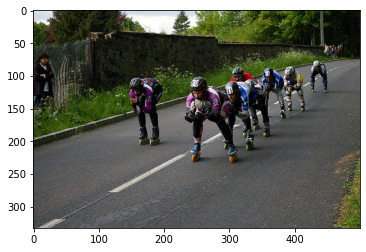

Expert Caption: ['group of rollerbladers is lined up on the street', 'group of rollerblading on sloping road', 'line of rollerbladers crouch down aerodynamically', 'many people are rollerblading down the street', 'rollerbladers roll in formation down hill']
Blue score 2.2250738585072626e-308
caption: bikers are riding on road covered in the


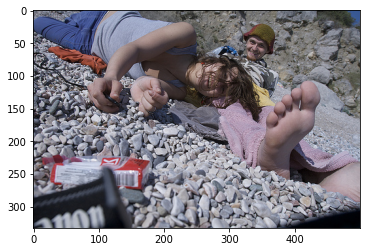

Expert Caption: ['laughing woman leans on the legs of sitting man while lying on bed of pebbles', 'woman and barefoot man lay down on rocky terrain', 'laying on stones girl with messy hair has her head on the boy laying next to her', 'the two people are lying in gray rocks', 'young man and woman stretch out on stones packages in foreground']
Blue score 1.928867353251809e-308
caption: two children are playing in the water


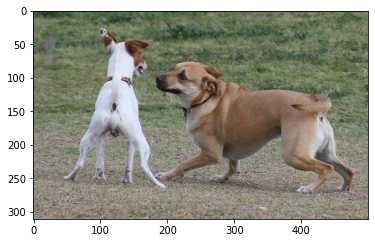

Expert Caption: ['big brown dog chases smaller white dog around in the grass', 'terrier dog and mixed breed dog playing', 'white dog and brown dog fighting', 'the white and brown dog are playing in the dead grass', 'two dogs paying attention to each other']
Blue score 0.4
caption: two dogs playing with each other


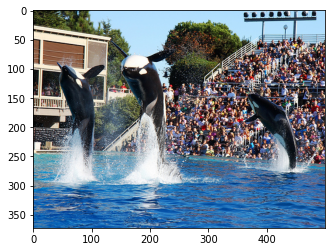

Expert Caption: ['killer whales perform for crowd', 'three dolphins are jumping out of pool in front of crowd of people', 'three orca whales jump in pool at seaworld', 'three whales are jumping into the air at the same time in front of very large crowd', 'three whales are jumping in the air while people watch']
Blue score 2.2250738585072626e-308
caption: children are playing in water water


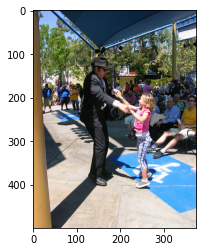

Expert Caption: ['man and girl stand in front of large crowd', 'man dances with girl', 'man in suit dances with young girl in front of an audience', 'man wearing black dances with young girl wearing pink shirt', 'the man wearing the blues brothers suit is dancing with the little girl in the pink top']
Blue score 0.16666666666666669
caption: man in white shirt is waiting to the side of an open cart


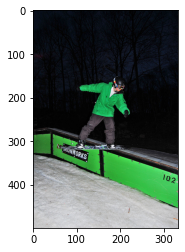

Expert Caption: ['helmeted boy flies through the air on snowboard', 'snowboarder balancing on wall', 'snowboarder in green grinds along the edge of rail at night', 'snowboarder wearing green jacket jumping green rainling', 'snowboarder wearing green jacket jumps above low gate']
Blue score 0.07142857142857141
caption: skateboarder in green shirt and blue pants riding on the handrail of front of playground


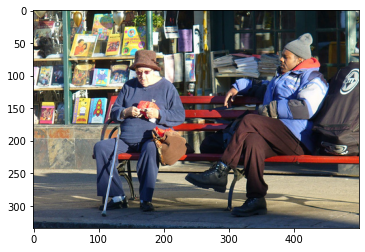

Expert Caption: ['an older man is sitting on red bench with younger man', 'an older person is sitting on red bench next to black man with children bookstore behind them both', 'person sits on red bench to eat while another watches', 'two men sit on bench', 'two people sitting on red bench in front of books']
Blue score 0.1112572547244864
caption: woman in black shirt is standing on bench


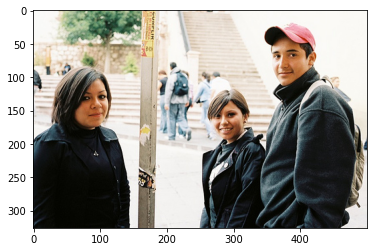

Expert Caption: ['man and two women standing by wood pole in front of steps', 'three students standing together in front of stairway', 'three young adults look towards the camera in school setting', 'two women and man are all wearing black jackets and smiling', 'two women and man smile for the camera']
Blue score 2.2250738585072626e-308
caption: man in blue coat is standing next to man in yellow hat


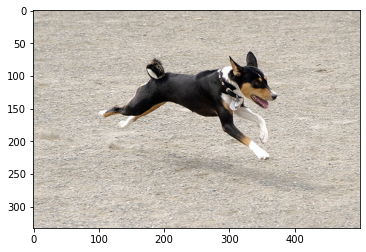

Expert Caption: ['brown black and white dog runs along on the gravel', 'dog runs', 'little dog running on sand', 'the brown white and black dog runs on gravel surface', 'the dog is running across the gravel']
Blue score 2.2250738585072626e-308
caption: two dogs are playing in the snow


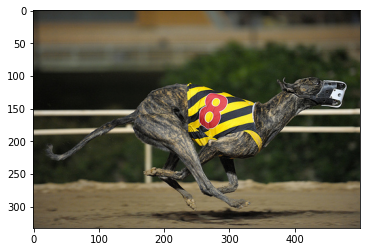

Expert Caption: ['dog wearing number running in race', 'greyhound dog wearing yellow and black shirt runs along dirt racetrack', 'greyhound runs in race bee striped jacket number eight', 'grey dog with muzzle and with the yellow striped identification is running', 'racedog has the number']
Blue score 2.2250738585072626e-308
caption: the bird is flying through the air


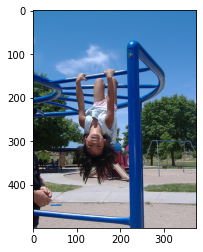

Expert Caption: ['child playing on the monkey bars at playground with an adult present', 'girl hangs on the bars', 'kid hangs upside down on the monkey bars at playground', 'young children hanging upside at the playground', 'girl hanging upside down on blue monkey bars']
Blue score 0.11111111111111109
caption: two children are jumping in the air on the street


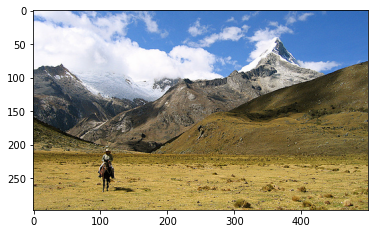

Expert Caption: ['man on horseback on grassy field in front of mountains', 'person on brown horse in prairie in front of tall mountains', 'person riding horse with mountain range in the far background', 'rider on horse in front of mountain range', 'distant horse rider on plain in the middle of brown mountains']
Blue score 2.2250738585072626e-308
caption: person stands on top of hill looking at the valley


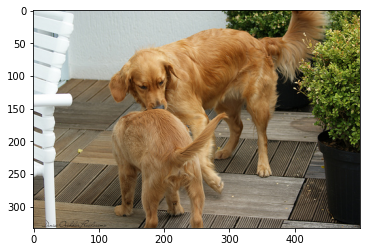

Expert Caption: ['large dog sniffing smaller dog outside', 'two blond dogs are standing together on patio', 'two dogs are standing together on patio', 'two golden dogs are standing on wooden patio', 'two golden dogs on wood deck']
Blue score 2.2250738585072626e-308
caption: dog stands on its hind legs


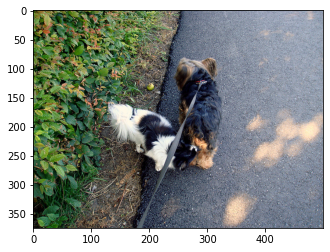

Expert Caption: ['brown and black dog on leash is sniffed by black and white dog', 'dog on leash walks on the sidewalk while another dog follows', 'small dog on leash is being smelled by another animal', 'the black and white dog is sniffing the butt of the brown dog that is on leash', 'two small dogs one blackandwhite and one brownandblack walk down the street']
Blue score 1.991083571408152e-308
caption: two dogs are running through field of dry flowers


In [156]:
for z in range(25):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  img_caption = greedySearch(image)
  bleu_score = get_bleuscore(img_caption,pic)
  #print("image name",pic)
  print("Blue score",bleu_score)
  print("caption:", img_caption)